In [1]:
import pandas as pd
import numpy as np
import math
import time
import seaborn as sns

In [2]:
df = pd.read_csv("CleanedTitanic.csv")
df.drop(['Unnamed: 0'], inplace=True, axis=1)

In [3]:
# Test/Train Split
length = len(df.index)
splitPoint = int(length * 0.7)
train = df[0:splitPoint]
test = df[splitPoint:length]

In [4]:
df

,Survived,Sex,Age,Parch,Fare,Embarked_S,Embarked_C,Embarked_Q,First Class,Second Class,Third Class
0,0,0,0.271174,0.000000,0.014151,1,0,0,0,0,1
1,1,1,0.472229,0.000000,0.139136,0,1,0,1,0,0
2,1,1,0.321438,0.000000,0.015469,1,0,0,0,0,1
3,1,1,0.434531,0.000000,0.103644,1,0,0,1,0,0
4,0,0,0.434531,0.000000,0.015713,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
707,0,1,0.484795,0.833333,0.056848,0,0,1,0,0,1
708,0,0,0.334004,0.000000,0.025374,1,0,0,0,1,0
709,1,1,0.233476,0.000000,0.058556,1,0,0,1,0,0
710,1,0,0.321438,0.000000,0.058556,0,1,0,1,0,0


# K-NN Algorithm

In [5]:
# K-NN Training Algorithm
def trainKNN(df, iterations):
  '''
  Pseudocode Algorithm
  1. Set K to 3 because this is the first odd value greater than the number of categories in the Titanic dataset.
  2. Create an empty list to collect accuracy values during training.
  2. Segment the training dataset into three equal parts: 
    - Segment 1: Class 1 labels
    - Segment 2: Class 2 labels
    - Segment 3: Remaining data of "unknown" labels 
  3. Calculate the euclidean distance between each data point in segment 3 with all data in segment 1 and segment 2. 
  4. Take the top K smallest distances to determine the label of the "unknown" data point.
  5. Append 0 to accuracy list if the label does not match the actual label. Append 1 to accuracy list if the label does match the actual label.
  6. Calculate the overall accuracy percent of the K value and append it to a dictionary of k, accuracy values.
  7. Add 2 to K and repeat steps 3 - 6 for a desired number of iterations.
  '''
  # Set initial value of k
  k = 3

  # Segment training data into 3 segments.
  class1, class2, unknowns = getSegments(df)
  
  # Calculate accuracy of K values for desired iterations
  count = 0
  accuracies = {}
  t0 = time.time() # for measuring how long it takes to compute
  t0_k = k
  while count < iterations:
    if count % 10 == 0:
      elapsed = time.time() - t0
      t0 = time.time()
      print(f"Took {elapsed:.2f} seconds to compute {t0_k}<=k<{k}")
      t0_k = k
    # Calculate percent accuracy for current k
    accuracy_at_k = calculateAccuracy(class1, class2, unknowns, k)
    accuracies[k] = accuracy_at_k
    k = k + 2
    count = count + 1
  
  return accuracies

# Helper Functions

In [6]:
def getSegments(df):
  # Segment training data into 3 segments. If not divisible by 3, add extra data to unknown segment.
  length = len(df.index)
  splitPoint = int(length/3)
  survived = df[df.Survived == 1]
  died = df[df.Survived == 0]
  survived_df = survived.iloc[:splitPoint]
  died_df = died.iloc[:splitPoint]
  leftover = pd.concat([survived.iloc[splitPoint:], died.iloc[splitPoint:]])
  survived.reset_index(inplace=True, drop=True)
  died.reset_index(inplace=True, drop=True)
  leftover.reset_index(inplace=True, drop=True)
  return survived_df, died_df, leftover

In [7]:
cache = {}
def calculateAccuracy(class1, class2, unknowns, k):
  known = pd.concat([class1, class2], axis=0)
  unknown_prediction_correct = []
  for idx in unknowns.index:
    if not idx in cache:
      cache[idx] = known.apply(lambda x: euclidianDistance(x, unknowns.iloc[idx]), axis=1)
    known['distance_to_unknown'] = cache[idx]
    top_k = known.sort_values('distance_to_unknown',ascending=True).head(k)
    predicted_class = top_k.value_counts(ascending=False, subset='Survived').index[0] # TODO: double check this line
    unknown_prediction_correct.append(1 if predicted_class == unknowns.iloc[idx].Survived else 0)
    known.pop('distance_to_unknown') # remove this so we don't use it in future distance calculations
  return sum(unknown_prediction_correct) / len(unknown_prediction_correct)

In [8]:
def euclidianDistance(row1, row2):
  sum = 0
  for (i, j) in zip(row1[1:10], row2[1:10]):
    diffSQ = (i - j) **2
    sum = sum + diffSQ
  return math.sqrt(sum)

# Result of calling trainKNN

In [9]:
performance = trainKNN(train, 100)

Took 0.00 seconds to compute 3<=k<3
Took 9.05 seconds to compute 3<=k<23
Took 1.70 seconds to compute 23<=k<43
Took 1.60 seconds to compute 43<=k<63
Took 1.65 seconds to compute 63<=k<83
Took 1.58 seconds to compute 83<=k<103
Took 1.63 seconds to compute 103<=k<123
Took 1.79 seconds to compute 123<=k<143
Took 1.65 seconds to compute 143<=k<163
Took 1.67 seconds to compute 163<=k<183


In [10]:
print(performance)

{3: 0.7951807228915663, 5: 0.7771084337349398, 7: 0.8072289156626506, 9: 0.8072289156626506, 11: 0.8132530120481928, 13: 0.8072289156626506, 15: 0.8012048192771084, 17: 0.8072289156626506, 19: 0.7831325301204819, 21: 0.7831325301204819, 23: 0.7771084337349398, 25: 0.7891566265060241, 27: 0.7771084337349398, 29: 0.7771084337349398, 31: 0.7831325301204819, 33: 0.7831325301204819, 35: 0.7650602409638554, 37: 0.7650602409638554, 39: 0.7650602409638554, 41: 0.7650602409638554, 43: 0.7650602409638554, 45: 0.7710843373493976, 47: 0.7710843373493976, 49: 0.7831325301204819, 51: 0.7831325301204819, 53: 0.7891566265060241, 55: 0.7831325301204819, 57: 0.7891566265060241, 59: 0.7951807228915663, 61: 0.7831325301204819, 63: 0.7831325301204819, 65: 0.7771084337349398, 67: 0.7891566265060241, 69: 0.7831325301204819, 71: 0.7831325301204819, 73: 0.7891566265060241, 75: 0.7951807228915663, 77: 0.8012048192771084, 79: 0.8012048192771084, 81: 0.8012048192771084, 83: 0.8072289156626506, 85: 0.8072289156626

# Visualizing K Accuracy

In [11]:
kacc = pd.DataFrame({
    "k": list(sorted(performance.keys())),
    "accuracy": [performance[k] for k in sorted(performance.keys())]
})
kacc.head()

,k,accuracy
0,3,0.795181
1,5,0.777108
2,7,0.807229
3,9,0.807229
4,11,0.813253


<AxesSubplot:xlabel='k', ylabel='accuracy'>

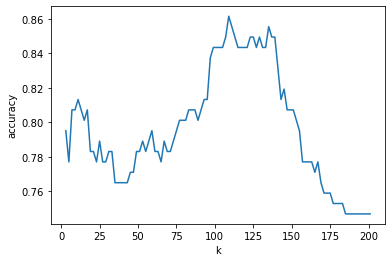

In [12]:
sns.lineplot(x=kacc.k, y=kacc.accuracy)

In [13]:
top = kacc.sort_values(by="accuracy", ascending = False)

In [14]:
top

,k,accuracy
53,109,0.861446
66,135,0.855422
54,111,0.855422
55,113,0.849398
67,137,0.849398
...,...,...
95,193,0.746988
96,195,0.746988
97,197,0.746988
98,199,0.746988


In [15]:
k = 109

In [29]:
len(df.columns)

11

In [49]:
def predictValues (train, test, k):
    testX = test.iloc[:, 1:11]
    testY = test.iloc[:, 0:1]
    predicted = {}
    for index, testX in testX.iterrows():
        sex1 = testX['Sex']
        age1 = testX['Age']
        parch1 = testX['Parch']
        fare1 = testX['Fare']
        s1 = testX['Embarked_S']
        c1 = testX['Embarked_C']
        q1 = testX['Embarked_Q']
        fc1 = testX['First Class']
        sc1 = testX['Second Class']
        tc1 = testX['Third Class']
        allDistance = {}
        for index, train in train.iterrows():
            sex2 = train['Sex']
            age2 = train['Age']
            parch2 = train['Parch']
            fare2 = train['Fare']
            s2 = train['Embarked_S']
            c2 = train['Embarked_C']
            q2 = train['Embarked_Q']
            fc2 = train['First Class']
            sc2 = train['Second Class']
            tc2 = train['Third Class']
            distance = ((sex1-sex2)**2 + (age1-age2)**2 + (parch1-parch2)**2 + (fare1-fare2)**2 + (s1-s2)**2 + (c1-c2)**2 + (q1-q2)**2 + (fc1-fc2)**2 + (sc1-sc2)**2 + (tc1-tc2)**2)**0.5
            allDistance = {distance:train['Survived']}
        
        

In [50]:
predictValues (train, test, k)

AttributeError: 'dict' object has no attribute 'sort_values'

In [20]:
df

,Survived,Sex,Age,Parch,Fare,Embarked_S,Embarked_C,Embarked_Q,First Class,Second Class,Third Class
0,0,0,0.271174,0.000000,0.014151,1,0,0,0,0,1
1,1,1,0.472229,0.000000,0.139136,0,1,0,1,0,0
2,1,1,0.321438,0.000000,0.015469,1,0,0,0,0,1
3,1,1,0.434531,0.000000,0.103644,1,0,0,1,0,0
4,0,0,0.434531,0.000000,0.015713,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
707,0,1,0.484795,0.833333,0.056848,0,0,1,0,0,1
708,0,0,0.334004,0.000000,0.025374,1,0,0,0,1,0
709,1,1,0.233476,0.000000,0.058556,1,0,0,1,0,0
710,1,0,0.321438,0.000000,0.058556,0,1,0,1,0,0


In [ ]:
def 